# MACE tutorial

MACE is an open source toolkit for the automated screening and discovery of octahedral and square-planar mononuclear complexes. The software generates all possible configurations for square-planar and octahedral metal complexes and atomic 3D coordinates suitable for quantum-chemical computations. It supports ligands of high complexity and can be used for the development of a massive computational pipelines aimed at solving problems of homogenious catalysis.

This document showcases the main features of MACE and provides example recipes of how to carry out particular tasks using the available functionality.

# Complex object

In MACE, the central entity is a `Complex` object. It can be generated from SMILES of the metal complex, from SMILES of ligands and a central atom, and from a MACE-generated `.xyz` file.

### Direct initialization

In MACE, the central entity is a `Complex` object. To initialize it, one requires SMILES of the metal complex and geometry of the central atom. SMILES must satisfy the following conditions:

1. Donor atoms of ligands have non-zero atomic map number: 1-6 for octahedral (`geom = 'OH'`) and 1-4 for square-planar (`geom = 'SP'`) geometries. This enumeration is used to describe a spatial arrangement of ligands around a central atom:

<img src="pics/geoms_scheme.png" width="30%">

2. Other atoms have unspecified atomic map number and isotopic number, except where otherwise noted (see the "Adding substituents" subsection);

3. Bonds between central atom and ligands are dative;

4. The complex contains one central atom only.

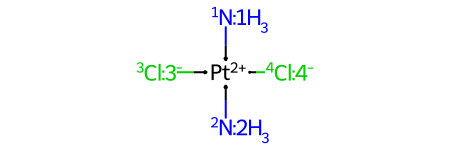

In [1]:
import mace

X = mace.Complex(smiles = '[NH3:1]->[Pt+2](<-[NH3:2])(<-[Cl-:3])(<-[Cl-:4])', geom = 'SP')
X.mol

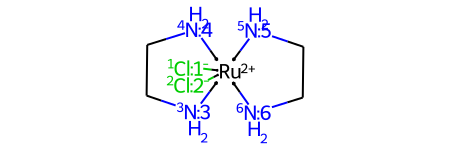

In [2]:
X = mace.Complex(smiles = '[Cl-:1]->[Ru+2](<-[Cl-:2])(<-[NH2:3]CC1)(<-[NH2:4]1)(<-[NH2:5]CC1)(<-[NH2:6]1)', geom = 'OH')
X.mol

The third argument `maxResonanceStructures` can be ignored in most cases. It is needed for complexes containing symmetrical multidentate ligands with an asymmetric arrangement of multiple bonds in the resonance structure used in the SMILES string. It will be discussed in more details in the "Issue of resonance structures" section.

The other way to generate the `Complex` object is to generate it from the ligands:

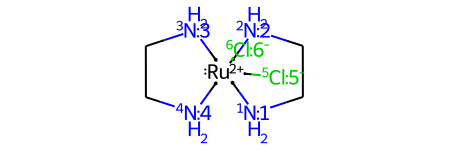

In [3]:
ligands = ['[NH2:1]CC[NH2:2]', '[NH2:3]CC[NH2:4]', '[Cl-:5]', '[Cl-:6]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
X.mol

Finally, `Complex` can be read from MACE-generated `xyz`-file. However, that is possible if only `Complex` has at least one conformer. Thus, it will be discussed in the "Embedding" section.

### SMILES notations

MACE uses [RDKit](https://www.rdkit.org/docs/RDKit_Book.html#smiles-support-and-extensions) and [ChemAxon](https://docs.chemaxon.com/display/docs/smiles.md) SMILES specifications which support dative bonds (unlike much more popular [Daylight SMILES](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html) and [OpenSMILES](http://opensmiles.org/opensmiles.html)).

RDKit SMILES is most convenient with manual generation for relatively small metal complexes, though this requires some experience with the SMILES notation. On the contrary, ChemAxon SMILES can be generated for any metal complex using the [ChemAxon Marvin](https://chemaxon.com/marvin) chemical editor. For the purpose, one need to draw the complex, arrange the atomic map numbers, and copy the structure as ChemAxon SMILES:

<img src="pics/marvin_get_smiles.png">

## Embedding

If atomic map numbers of donor atoms are correct (no repeats, lies in range \[1,6\]/\[1,4\] for OH/SP geometry, etc.), than one can generate 3D atomic coordinates:

In [4]:
import py3Dmol

def view_complex(X, confId = 0):
    '''Shows molecule corresponding to the SMILES'''
    view = py3Dmol.view()
    view.addModel(X.ToXYZBlock(confId = confId), 'xyz')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.3}})
    view.setBackgroundColor('white')
    view.zoomTo()
    
    return view

ligands = ['[NH2:1]CC[NH2:2]', '[NH2:3]CC[NH2:4]', '[Cl-:5]', '[Cl-:6]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
X.AddConformer()
view_complex(X)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

If the atomic map numbers are set incorrectly, one must first generate possible stereomers (see the "Stereomers generation" section):

In [5]:
ligands = ['[NH2:1]CC[NH2:1]', '[NH2:1]CC[NH2:1]', '[Cl-:1]', '[Cl-:1]']
X1 = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
try:
    X1.AddConformer()
except Exception as e:
    print(e)

Bad SMILES: isotopic labels are not unique

The initial SMILES contains insufficient or erroneous info
on the positions of the ligands around the central atom
encoded with isotopic labels.
To use 3D generation and other features, generate
possible stereomers by passing this Complex object
to GetComplexStereomers function with "CA" or "all" regime.




The main parameters of `Complex.AddConformers` method are number of conformers to generate `numConfs` and minimal RMSD between conformers when they are considered as identical `rmsThresh`:

In [6]:
ligands = ['C[P:2](C)CCC[N:3](C)CCC[P:4](C)C', '[C-:1]#[O+]', '[C-:5]#[O+]', '[C-:6]#[O+]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
X.AddConformers(numConfs = 10, rmsThresh = 2.0)
X.GetNumConformers()

4

As one can see, number of generated conformers is less than `numConfs` value due to the filtering of similar conformations.

Analysis of molecular mechanical energies help to identify "good" and "bad" (potentially unsuitable for QM computations) geometries:

In [7]:
Es = [round(X.mol3Dx.GetConformer(idx).GetDoubleProp("E"), 1) for idx in range(X.GetNumConformers())]
Es

[121.9, 121.9, 121.9, 121.9]

In [8]:
import numpy as np
# best conformation
view_complex(X, confId = int(np.argmin(Es)))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [9]:
# worst conformation
view_complex(X, confId = int(np.argmax(Es)))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Generated conformations can be saved to the `xyz` files, which can be used futher in various computational pipelines:

In [10]:
path = 'Ru_PNP_CO3.xyz'
X.ToXYZ(path)
with open(path, 'r') as inpf:
    for _ in range(10):
        print(inpf.readline(), end = '')
    print('...')

48
{"conf": 0, "E": 121.86, "rms": -1.0, "geom": "OH", "total_charge": 2, "CA_charge": 2, "smiles": "C[2P:1]1([CH3:2])->[Ru+2:20]2(<-[1C-:14]#[O+:15])(<-[5C-:16]#[O+:17])(<-[6C-:18]#[O+:19])<-[3N:6]([CH3:7])([CH2:5][CH2:4][CH2:3]1)[CH2:8][CH2:9][CH2:10][4P:11]->2([CH3:12])[CH3:13]", "smiles3D": "C([2P:1]1([C:2]([H:24])([H:25])[H:26])->[Ru+2:20]2(<-[1C-:14]#[O+:15])(<-[5C-:16]#[O+:17])(<-[6C-:18]#[O+:19])<-[3N:6]([C:7]([H:33])([H:34])[H:35])([C:5]([H:31])([H:32])[C:4]([H:29])([H:30])[C:3]1([H:27])[H:28])[C:8]([H:36])([H:37])[C:9]([H:38])([H:39])[C:10]([H:40])([H:41])[4P:11]->2([C:12]([H:42])([H:43])[H:44])[C:13]([H:45])([H:46])[H:47])([H:21])([H:22])[H:23]", "smiles3Dx": "C([2P:1]1([C:2]([H:24])([H:25])[H:26])->[Ru+2:20]2(<-[1C-:14]#[O+:15])(<-[5C-:16]#[O+:17])(<-[6C-:18]#[O+:19])<-[3N:6]([C:7]([H:33])([H:34])[H:35])([C:5]([H:31])([H:32])[C:4]([H:29])([H:30])[C:3]1([H:27])[H:28])[C:8]([H:36])([H:37])[C:9]([H:38])([H:39])[C:10]([H:40])([H:41])[4P:11]->2([C:12]([H:42])([H:43])[H:44])[C:13

The second line of the file contains JSON with information required to regenerate `Complex` object:

In [11]:
X = mace.ComplexFromXYZFile(path)
X.GetNumConformers()
view_complex(X, confId = int(np.argmin(Es)))

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
# remove junk
import os
os.remove(path)

## Stereomers generation

The main part of the MACE package is a stereomer-search functionality:

In [13]:
ligands = ['[NH2:1]CC[NH2:1]', '[NH2:1]CC[NH2:1]', '[F-:1]', '[F-:1]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
Xs = X.GetStereomers()
len(Xs)

2

In [14]:
emin_idxs = {}
for idx, X in enumerate(Xs):
    X.AddConformers(numConfs = 10)
    Es = [X.mol3Dx.GetConformer(i).GetDoubleProp('E') for i in range(X.GetNumConformers())]
    emin_idxs[idx] = int(np.argmin(Es))
view_complex(Xs[0], confId = emin_idxs[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
view_complex(Xs[1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Further in this section we will review the main parameters of stereomer search and some important usage scenarios

### Stereochemistry control

There are three regimes stereomer search (`regime` parameter):

* "CA": changes stereochemistry of the central atom only, ignores undefined stereocenters in ligands;

* "ligands": changes stereochemistry of undefined stereocenters in ligands only, ignores central atom;

* "all": default choice, changes stereochemistry of all undefined stereocenters.

`ligands` regime can be useful if one want to fix stereochemistry of the central atom. This could be the case for ligands containing aliphatic amine donor group with three different substituents, which will form a chiral center after binding to the metal:

In [16]:
ligands = ['C[N:1](C)CC[N:2](C)CC[P:3](C)C', '[C-:4]#[O+]', '[H-:5]', '[H-:6]']
X = mace.ComplexFromLigands(ligands = ligands, CA = '[Ru+2]', geom = 'OH')
Xs = X.GetStereomers(regime = 'ligands')
len(Xs)

2

In [17]:
emin_idxs = {}
for idx, X in enumerate(Xs):
    X.AddConformers(numConfs = 3)
    Es = [X.mol3Dx.GetConformer(i).GetDoubleProp('E') for i in range(X.GetNumConformers())]
    emin_idxs[idx] = int(np.argmin(Es))
view_complex(Xs[0], confId = emin_idxs[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [18]:
view_complex(Xs[1], confId = emin_idxs[1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Using this regime, one should remember that some of conformers are diastereomers.

There are almost no problems where the `CA` regime will be preferable. Indeed, if original ligands has undefined stereocenters, conformers of identified stereomers will not be true conformers in general case, but diastereomers. Therefore, it should be used carefully.

On the contrary, the `all` regime can be used in almost any situation.

The other parameter controlling stereomers search is `dropEnantiomers`. If `True`, it reduces pairs of enantiomers to one complex:

In [19]:
ligands = ['[NH2:1]CC[NH2:1]', '[NH2:1]CC[NH2:1]', '[NH2:1]CC[NH2:1]']
X = mace.ComplexFromLigands(ligands, '[Ru+2]', 'OH')
len(X.GetStereomers(dropEnantiomers = True))

1

In [20]:
len(X.GetStereomers(dropEnantiomers = False))

2

Consideration of both enantiomers may be necessary only if the complex is in a chiral environment that is not its ligand, which is quite rare for homogeneous catalysis.

### Rule-based filtering

Unlike monodentate ligands, relative positions of donor atoms in complexes of chelates and multidentate ligands are restricted by the ligand's structure. The most obvious scenario is coordination of bidentate ligand: unless the ligand is "long", donor atoms can not be in *trans-* position to each other. In MACE, this idea is controlled by the `minTransCycle` parameter, which is the minimal size of the ..DA->M<-DA.. cycle, where DA are in trans- position to each other and belong to one ligand:

In [21]:
X = mace.ComplexFromLigands(['[NH2:1]CCCCCCCCCCCCC[NH2:1]', '[Cl-:1]', '[Cl-:1]'], '[Pt+2]', 'SP')
len(X.GetStereomers(minTransCycle = None)) # default, those DAs can not be in trans-position never

1

In [22]:
Xs = X.GetStereomers(minTransCycle = 12)
len(Xs)

2

In [23]:
for X in Xs:
    X.AddConformer()
view_complex(Xs[0])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
view_complex(Xs[1])

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

`merRule` is another similar parameter. It restricts "rigid" DA-DA-DA fragments (e.g. terpyridine) to be in meridial conformation:

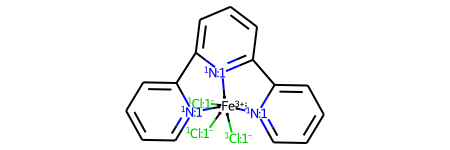

In [25]:
ligands = ['[n:1]1ccccc1-c([n:1]1)cccc1-c1cccc[n:1]1', '[Cl-:1]', '[Cl-:1]', '[Cl-:1]']
X = mace.ComplexFromLigands(ligands, '[Fe+3]', 'OH')
X.mol

In [26]:
len(X.GetStereomers(merRule = True))

1

In [27]:
len(X.GetStereomers(merRule = False))

2

In most cases merRule nicely filters "impossible" stereomers, though experience shows that in some cases it throws out energetically possible structures due to simplicity of the "rigidity"-determining algorithm. Thus this parameter should be treated carefully, especially for new systems.

### Issue of resonance structures

The main part of MACE implementation of stereomers generation algorithm is a pairwise comparison of isomers which is based on molecular graphs. Some symmetrical conjugated systems have non-symmetrical molecular graph, e.g. dithiocarboxylates. Indeed, in both sulfur atoms in `CC(=S)[S-]` are identical, even though in molecular graph one atom forms a single bond and the other forms a double bond. When such ligands will act as bidentate ligands, there are possibility that the final set of isomers will contain identical systems:

In [28]:
smiles = '[Pd+2](<-[S-:1]1)(<-[S:2]=C1C)(<-[S-:3]1)(<-[S:4]=C1C)'
X1 = mace.Complex(smiles, 'SP', maxResonanceStructures = 1)
X1_isomers = X1.GetStereomers()
len(X1_isomers)

2

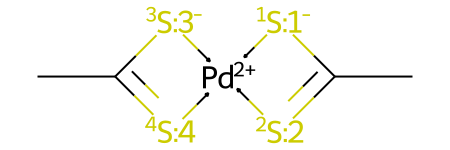

In [29]:
X1_isomers[0].mol

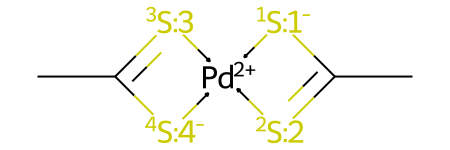

In [30]:
X1_isomers[1].mol

In MACE this problem is solved for carboxylates and NCN-carbenes, but for other systems one should use `maxResonanceStructures` parameter during `Complex` initialization. It is a number of resonance structures which will be considered for the complex during generation of a data structure for isomers' comparison. The larger its value, the higher the probability of filtering duplicated stereomers:

In [31]:
X2 = mace.Complex(smiles, 'SP', maxResonanceStructures = 4)
X2_isomers = X2.GetStereomers()
len(X2_isomers)

1

However, such approach can be extremely time consuming for large conjugated systems.

## Special features

### Adding substituents

One of the most popular problems in computational chemistry is the search for the most efficient system by introducing various substituents to the core structure. To make such tasks easier, MACE contains functionality for introducing substituents to both ligands and complexes. To use it, one need to start with getting ChemAxon SMILES of the ligand with R/R1/R2/etc substituents:

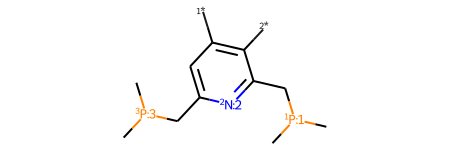

In [32]:
ligand = 'C[P:3](C)CC1=CC([*])=C([*])C(C[P:1](C)C)=[N:2]1 |$;;;;;;;_R1;;_R2;;;;;;$,c:14,t:4,7|'
L = mace.MolFromSmiles(ligand)
L

or to use specify substituents as dummy atoms in RDKit SMILES format. To add substituents to the ligand one need to use `mace.AddSubsToMol` function:

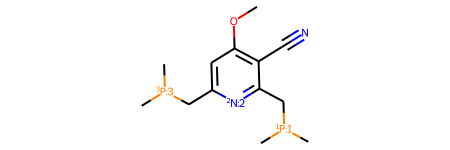

In [33]:
subs = {'R1': mace.MolFromSmiles('[*]OC'),
        'R2': mace.MolFromSmiles('[*]C#N')}
ligand_sub = mace.AddSubsToMol(L, subs)
ligand_sub

For the complex, the same procedure is a little trickier:

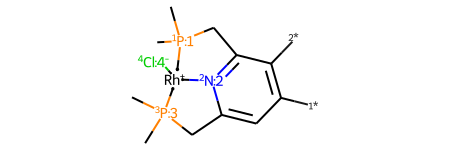

In [34]:
core = mace.ComplexFromLigands([ligand, '[Cl-:4]'], '[Rh+]', 'SP')
core.mol

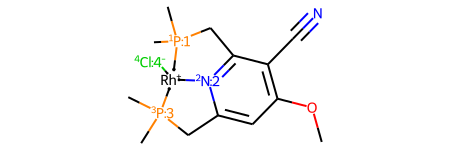

In [35]:
X = mace.ComplexFromMol(mace.AddSubsToMol(core.mol, subs), core._geom)
X.mol

### Constrained embedding

When analyzing conformations of complexes with one core and different substituents, constrained embedding can be a nice solution. The idea is to fix the geometry of the core and optimize coordinates of other atoms. In MACE this is implemented in the `AddConstrainedConformer` / `AddConstrainedConformers` methods. Compared to the `AddConstrainedConformer` / `AddConstrainedConformers` methods, they take additional parameter `core` which must be (1) a `Complex` object, (2) substructure of the current `Complex`, and (3) must have at least one generated conformer:

In [36]:
core.AddConformer()
view_complex(core)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
X.AddConstrainedConformer(core, confId = core.GetMinEnergyConfId(0))
view_complex(X)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Currently MACE supports monovalent substituents only.

### Prepare ligands for MolSimplify

Like MACE, [MolSimplify](https://github.com/hjkgrp/molSimplify) is a package for the automated screening and discovery of new inorganic molecules. It uses OpenBabel as 3D embedding engine, and fails generating conformers of complex multidentate ligands from SMILES. However, it works perfectly fine if the ligand already have pregenerated geometry which in most cases has to be prepared manually.

Lucky for us, MACE can be used to automatically generate conformations of coordinated ligands with a structure of almost any complexity. For the purpose, one must generate 3D coordinated for any complex containing desired ligand, and cut it from the complex using the `GetBondedLigand` method (`num` parameter is an isotopic number of the ligand's donor atom):

In [38]:
ligands = ['[n:1]1ccccc1-c([n:2]1)cccc1CNCC[P:6](C)C', '[C-:3]#[O+]', '[C-:4]#[O+]', '[C-:5]#[O+]']
num = 1
X = mace.ComplexFromLigands(ligands, '[Ru+2]', 'OH')
Xs = X.AddConformers(numConfs = 10)
idx_min = X.GetMinEnergyConfId(0)
view_complex(X, idx_min)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [39]:
mol = X.GetBondedLigand(num)

from rdkit import Chem

def view_mol(mol, confId = 0):
    '''Shows molecule corresponding to the SMILES'''
    view = py3Dmol.view()
    view.addModel(Chem.MolToMolBlock(mol, confId = confId), 'mol')
    view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.3}})
    view.setBackgroundColor('white')
    view.zoomTo()
    
    return view

view_mol(mol, idx_min)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Obtained conformer can be save in `mol` / `xyz` format and stored in the molSimplify library of ligands.